In [30]:
from functools import partial

import numpy as np
from scipy.linalg import hankel
from scipy.stats import dirichlet, poisson, norm, zscore
from scipy.special import logsumexp
import statsmodels.api as sm

import pickle
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax
from jax import vmap
from PoissonRegressionHMM import PoissonRegressionHMM

from dynamax.hidden_markov_model import PoissonHMM
import matplotx
plt.style.use(matplotx.styles.aura["dark"])

In [11]:
with open("test_data_acc_ind_492_0607.pickle", "rb") as handle:
    data = pickle.load(handle)
print(data.keys())
total_neurons = len(data["spikes"])
print(f"n_neurons: {total_neurons}")
print("n_trials: {}".format(data["choice"].size))

dict_keys(['nCues_RminusL', 'currMaze', 'laserON', 'trialStart', 'trialEnd', 'keyFrames', 'time', 'cueOnset_L', 'cueOnset_R', 'choice', 'trialType', 'pos', 'spikes', 'timeSqueezedFR'])
n_neurons: 324
n_trials: 290


In [12]:
# constructing design matrix with all trials

neuron = 73
trial_indices = np.nonzero((data["currMaze"] > 7) * (data["laserON"] == 0))[0]
print(f"number of trials: {trial_indices.size}")
X = []
y = []
filt_len = 30
sp_filt_len = 50
bin_size = 0.05
trial_id = []
bin_positions = []
bin_centers_all = []

for trial_idx in trial_indices:
    keyframes = data["keyFrames"][trial_idx]
    keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
    trial_start = data["trialStart"][trial_idx]
    # trial_end = data["trialEnd"][trial_idx]
    # lcue_times = data["cueOnset_L"][trial_idx]
    # rcue_times = data["cueOnset_R"][trial_idx]
    # trial_start = keyframe_times[0] + data["trialStart"][trial_idx]
    trial_end = keyframe_times[2] + trial_start
    lcue_times = data["cueOnset_L"][
        trial_idx
    ]  # - keyframe_times[0] # remove keyframe subtraction if using all phases of trial
    rcue_times = data["cueOnset_R"][trial_idx]  # - keyframe_times[0]

    trial_length = trial_end - trial_start
    spikes = data["spikes"][neuron]
    spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]

    bins = np.arange(0, trial_length, bin_size)
    bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")
    bin_centers_all.append(bin_centers)

    time = data["time"][trial_idx][:, np.newaxis]
    pos = data["pos"][trial_idx][:, 1]
    bin_centers = bin_centers.reshape(-1, 1)
    dist = time[: pos.size].T - bin_centers
    bin_time_index = np.argmin(np.abs(dist), axis=1)
    binned_pos = pos[bin_time_index]
    bin_positions.append(binned_pos)
    means = np.linspace(0, 275, 10)
    pos_gauss = []
    for mu in means:
        dist = norm(mu, 10)
        pos_gauss.append(dist.pdf(binned_pos))
    pos_gauss = np.array(pos_gauss)

    binned_stimr, _ = np.histogram(rcue_times, bins)
    binned_stiml, _ = np.histogram(lcue_times, bins)
    binned_spikes, _ = np.histogram(spikes - trial_start, bins)
    binned_ev = np.cumsum(binned_stimr) - np.cumsum(binned_stiml)

    padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
    X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
    padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
    X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])
    padded_ev = np.pad(binned_ev, (filt_len - 1, 0), constant_values=(0, 0))
    X_ev = hankel(padded_ev[: -filt_len + 1], padded_ev[-filt_len:])

    padded_spikes = np.pad(binned_spikes[:-1], (sp_filt_len, 0), constant_values=(0, 0))
    X_sp = hankel(padded_spikes[: -sp_filt_len + 1], padded_spikes[-sp_filt_len:])

    trial_type = data["trialType"][trial_idx]
    # X_pos = np.hstack((trial_type * pos_gauss.T, (1 - trial_type) * pos_gauss.T))
    X_pos = pos_gauss.T
    # need to add second pos matrix for choice or evidence
    X.append(np.hstack((X_sr, X_sl, X_pos, np.ones((X_sp.shape[0], 1)))))
    # X.append(np.hstack((X_sr, X_sl, np.ones((X_sp.shape[0], 1)))))

    y.append(binned_spikes[:, np.newaxis])

    trial_id.append(trial_idx * np.ones(X_sr.shape[0]))


# zscore????
X = np.vstack(X)
X[:, : (filt_len * 2)] = zscore(X[:, :60], axis=None)
X[:, (filt_len * 2) : -1] = zscore(X[:, 60:-1], axis=0)
y = np.vstack(y)
trial_id = np.hstack(trial_id)
# ,
print(0, keyframe_times, trial_end - trial_start)
print(X.shape)
print(rcue_times)

number of trials: 210
0 [0.5845199823379517, 9.808429718017578, 125.71129608154297, 126.09971618652344] 125.71129608154297
(35483, 71)
[5.7475414 6.7473097 7.474443  8.926171  9.242626 ]


transition matrix: 
[[0.94 0.01 0.05]
 [0.22 0.75 0.03]
 [0.   0.04 0.96]]


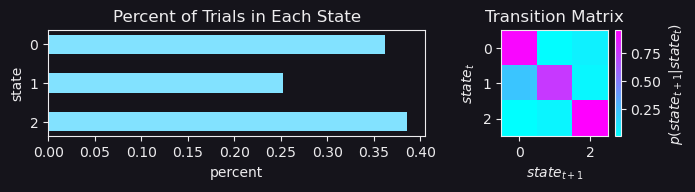

In [13]:
# Generating states for simulation
np.random.seed(1)
n_states = 3
t_init = np.array([1.4, 0.7, 0.7])[:n_states]
T_sim = np.array([dirichlet(np.roll(t_init**(n+1), n)).rvs()[0] for n in range(n_states)])
dist_init = np.array([0.8, 0.1, 0.1])[:n_states]
dist_init /= dist_init.sum()
sim_states = np.ones(trial_indices.size).astype(int)
for i in range(sim_states.size):
    if i == 0:
        sim_states[i] = np.random.choice(np.arange(n_states), 1, p=dist_init)
    sim_states[i] = np.random.choice(np.arange(n_states), 1, p=T_sim[sim_states[i-1]])

print(f'transition matrix: \n{np.round(T_sim, 2)}')
fig, axs = plt.subplots(1, 2, figsize=(7, 2), gridspec_kw={'width_ratios': [5, 2]})
_ = axs[0].hist(sim_states, bins=np.arange(-0.5, 2.51, 1), density=True, rwidth=0.5, orientation='horizontal')
axs[0].set_title('Percent of Trials in Each State')
axs[0].set_xlabel('percent')
axs[0].set_ylabel('state')
axs[0].set_ylim(axs[0].get_ylim()[::-1])
im = axs[1].imshow(T_sim, cmap='cool', origin='upper')
plt.colorbar(im, ax=axs[1], label='$p(state_{t+1} | state_t)$')
axs[1].set_title('Transition Matrix')
axs[1].set_ylabel(r'$state_t$')
axs[1].set_xlabel(r'$state_{t+1}$')
plt.tight_layout()

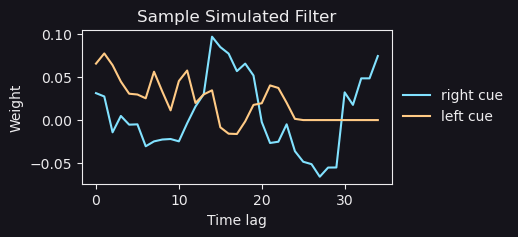

In [21]:
# generating parameters for each state for each neuron
# np.random.seed(0)
n_neurons = 2
n_filters = 2
theta_sim = np.empty((n_states, X.shape[1], n_neurons))
for n in range(n_neurons):
    for s in range(n_states):
        for f in range(n_filters):  # 2 filters, right stim, left stim, (no spikes for simulated data)
            for i in range(filt_len):
                if i == 0:
                    theta_sim[s, i+(f * filt_len), n] = np.random.normal(0, 0.1)
                    # theta_sim[s, i+(f * filt_len), n] = (s+1)**2
                else:
                    theta_sim[s, i+(f*filt_len), n] = np.random.normal(theta_sim[s, i+(f*filt_len)-1, n], .02)
                    # theta_sim[s, i+(f * filt_len), n] = (s+1)**2
        theta_sim[s, -1, n] = np.random.normal(0.15, 0.05) #bias term

fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(theta_sim[0, :-1, 1].reshape(2, -1).T, label=['right cue', 'left cue'])
ax.set_title('Sample Simulated Filter')
ax.set_xlabel('Time lag')
ax.set_ylabel('Weight')
plt.legend(bbox_to_anchor=(1.4, 0.7))


(35483, 2)


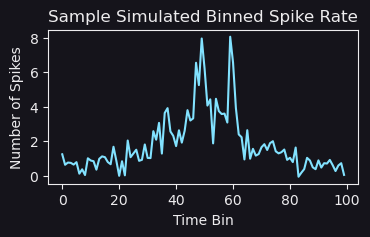

In [25]:
# generating spike rate data
y_sim = []
for i, trial in enumerate(np.unique(trial_id).astype(int)):
    x_idx = np.argwhere(trial_id==trial)
    y_sim.append(np.squeeze(X[x_idx] @ theta_sim[sim_states[i]]))

y_sim = np.exp(np.vstack(y_sim)) + np.random.normal(0, 0.5, size = (X.shape[0], n_neurons))
# y_sim = np.round(y_sim, 2)
print(y_sim.shape)
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(y_sim[:100, 0])
ax.set_title('Sample Simulated Binned Spike Rate')
ax.set_xlabel('Time Bin')
ax.set_ylabel('Number of Spikes');


In [26]:
#initial glm with no states to estimate weights
theta_init = np.empty(theta_sim[0].shape)
sta = (X.T @ y_sim) / y_sim.sum()
glms = [None for _ in range(n_neurons)]

for neuron in range(n_neurons):
    glm = sm.GLM(endog=y_sim[:, neuron], exog=X, family=sm.families.Poisson())
    glms[neuron] = glm
    a = 0.001 * np.ones(X.shape[1])
    a[-1] = 0
    res = glm.fit_regularized(alpha=a, L1_wt=0.0, maxiter=1000, cnvrg_tol=1e-6)

    w = res.params
    theta_init[:, neuron] = w


/usr/people/ye9829/.conda/envs/mybase/envs/towers/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1375: UserWarning: GLM ridge optimization may have failed, |grad|=215902861.324672
  warnings.warn(msg)


In [30]:
n_states = 3


In [37]:
def get_poiss_ll(X, y, theta):
    v = X @ theta
    r = np.exp(v)
    ll = y * np.log(r) - r
    ll = ll.sum(axis=(1, 2))
    # print(ll.shape)
    return ll - logsumexp(ll)


# n_trials = np.unique(trial_id).size
# print(n_trials)
# theta_hmm = np.ones((n_states, X.shape[1], n_neurons)) * theta_init
# # adding noise to all the weights
# theta_hmm += np.random.normal(0, 0.1, size=theta_hmm.shape)

# loglikeli = np.empty((n_states, np.unique(trial_id).size))
# for t in np.unique(trial_id):
#     x_idx = np.argwhere(trial_id == t).squeeze()
#     loglikeli[:, t] = get_poiss_ll(X[x_idx], y_sim[x_idx], theta_hmm)
n_states = 3
model = PoissonRegressionHMM(
    num_states=n_states,
    input_dim=X.shape[1],
)

params, props = model.initialize()
# posterior = model.smoother(params, emissions=params.emissions.rates)

In [45]:
model.fit_em(params, props, inputs=X)

TypeError: fit_em() missing 1 required positional argument: 'emissions'

AttributeError: 'ParamsPoissonRegressionHMM' object has no attribute 'properties'